# Demonstration of Dynamic Simulation (34-Bus Enter Service)

This example demonstrate how to use OpenDER to conduct a dynamic simulation. This example is converted and simplified from the python script example [here](../OpenDSS_34bus/pymodel/dynamic_simulation.py).

The test circuit is a modified IEEE 34-bus system. The original circuit definition can be found [here](https://cmte.ieee.org/pes-testfeeders/resources/). More discussion on the circuit can be found in [Example 2](./Ex2_Steady-state%20Simulation%20(34-Bus).ipynb). The circuit diagram is as shown below.

![Circuit Diagram](../OpenDSS_34bus/IEEE_34Bus/circuit.png).

This example shows the impact of DER enter service performance and its interactions with voltage regulators. User may change the enter service delay time (ES_DELAY) and enter service ramp time (ES_RAMP_RATE) to observe the impact.

![DER enter service performance](../OpenDSS_34bus/IEEE_34Bus/enter_service.png).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    
import pathlib
import os
from opender_interface.der_interface import DERInterface
from opender_interface.opendss_interface import OpenDSSInterface
from opender_interface.time_plots import TimePlots
from opender import DERCommonFileFormat

In [2]:
# circuit path
script_path = pathlib.Path(globals().get("__file__", "./_")).absolute()
circuit_folder = script_path.parents[1].joinpath("OpenDSS_34bus").joinpath("IEEE_34Bus")
dss_file = circuit_folder.joinpath("ieee34Mod2_der.dss")
print(dss_file)  # make sure path to the OpenDSS circuit is correct.

C:\Users\pyma001\PycharmProjects\OpenDER_interface_github\Examples\OpenDSS_34bus\IEEE_34Bus\ieee34Mod2_der.dss


In [3]:
# simulation time step
tstep = 1

# Create DERInterface
ckt = OpenDSSInterface(str(dss_file))
ckt_int = DERInterface(ckt, t_s=tstep, print_der=False)

# initialize circuit
ckt_int.initialize()

# create voltage regulator controls objects to replace the ones in the circuit
ckt_int.create_vr_objs()

In [4]:
# create an OpenDER object to each PVSystem in DSS circuit
der_file = DERCommonFileFormat(NP_VA_MAX=300e3,
                               NP_P_MAX=300e3,
                               NP_Q_MAX_INJ=132e3,
                               NP_Q_MAX_ABS=132e3,
                               QV_MODE_ENABLE=True,

                               ES_DELAY=300,
                               ES_RAMP_RATE=300,
                               ES_RANDOMIZED_DELAY=0,)

# In this example, a single DER configuration file is passed to the interface to create the OpenDER object.
# In this case, the OpenDER interface assumes all DERs has the same rating and control settings
# As another approach, a dictionary can be passed instead of this single configuration. This will be demonstrated in the next example
der_list = ckt_int.create_opender_objs(der_file, p_pu=1)

In [5]:
# add a fault branch to the circuit, disable the fault by setting very high impedance
ckt_int.cmd('New Fault.F1 Phases=3 Bus1={}'.format('808'))
ckt_int.cmd('Edit Fault.F1 R=1000000')

t = 0
%matplotlib agg
plot_obj = TimePlots(3, 1, ['DER output Power (kW)', 'Voltage Regulator Voltages (120V)', 'Voltage Regulator Tap Position'])

In [6]:
# Solve power flow to get an initial simulation condition to start the dynamic simulation. 
# For more information on the steady-state power flow solution, please refer to example 2
ckt_int.enable_control()
Ps, Qs = ckt_int.der_convergence_process()
ckt_int.read_vr()
ckt_int.update_vr_tap()
ckt_int.disable_control()

Note that during steady-state power flow solutions, the control elements (voltage regulators) in OpenDSS internal circuit is enabled.
Next, during dynamic simulations, the OpenDSS internal control elements are disabled. The voltage regulators' performance are modeled by external model in Python. This model is included in OpenDER interface package, named as VR_Model.

In [7]:
# dynamic simulation
while t < 1200:

    # event simulation
    if 45 < t < 50:
        ckt_int.cmd('Edit Fault.F1 R=0.01')
    else:
        ckt_int.cmd('Edit Fault.F1 R=1000000')

    # Obtain system voltage from previous power flow solution
    ckt_int.read_sys_voltage()
    # Simulate DER dynamics and voltage regulator logics
    ckt_int.run()
    # Update DER outputs to circuit simulation
    ckt_int.update_der_output_powers()
    # set the new tap position into opendss
    ckt_int.write_vr()
    # Solve load flow
    ckt_int.solve_power_flow()

    # get DER injection
    kw = sum([der.p_out_kw for der in ckt_int.der_objs])
    
    # save result
    result1 = {}
    result2 = {}
    result3 = {}
    result4 = {}

    for der in ckt_int.der_objs:
        result1['q_out_pu({})'.format(der.name)] = der.p_out_pu
        # result['qout({})'.format(der.name)] = der.q_out_kvar
        result3['v({})'.format(der.name)] = der.der_input.v_meas_pu
        # result3[f'debug({der.name})'] = der.enterservice.vft_delay.con_del_enable_out
        # result4[f'{der.name}'] = der.enterservice.vft_delay.con_del_enable_int

    for vr in ckt_int.vr_objs:
        if vr.name[-1]=='a':
            result4[f'Tap ({vr.name})'] = vr.tap
            result2[f'V ({vr.name})'] = vr.Vreg

    plot_obj.add_to_traces(
        {
            'Total DER Power (kw)': sum([der.p_out_kw for der in ckt_int.der_objs])
        },
        result2, result4
    )
    t = t + tstep

In [8]:
print('-------------------------------------------------------------')
print(f'Total number of tap operations is {sum([vr.total_sw for vr in ckt_int.vr_objs])}')

-------------------------------------------------------------
Total number of tap operations is 101


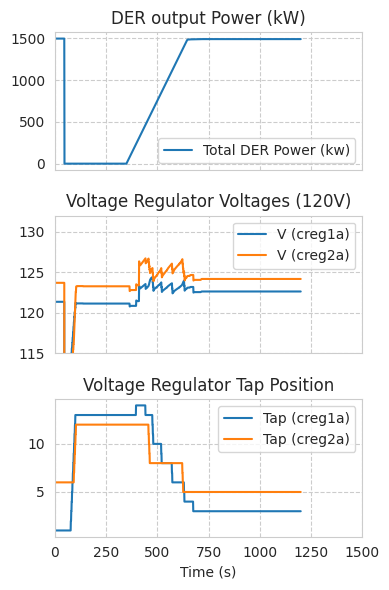

In [9]:
# plot figure
plot_obj.prepare()
for ax in plot_obj.axes:
    # ax.get_legend().remove()
    ax.grid(visible=True)
    ax.legend()  # ,fontsize='x-small')
    # ax.set_title(' ')

plot_obj.fig.set_size_inches(4, 6)
plot_obj.axes[1].set_ylim(115, 132)
plot_obj.axes[0].set_xlim(0, 1500)

plt.tight_layout()

%matplotlib inline
plot_obj.show()